### LIBRARIES

In [ ]:
!pip install fancyimpute

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from pandas.api.types import is_string_dtype, is_bool_dtype, is_datetime64_dtype
import pandas.api.types as ptypes
import numpy as np
import csv
import time

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
# from fancyimpute import IterativeImputer

### FUNCTIONS

In [ ]:
# Function to parse and categorize time of day
def categorize_time_of_day(mil_time):

    # Extract the hour from military time formatted as 'HH:MM:SS'
    hour = int(mil_time.split(':')[0])

    if 0 <= hour < 6:
        return 'Early Morning'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 14:
        return 'Noon'
    elif 14 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

# Function to convert FBI codes
def convert_FBI_codes(code):
    if 'A' in code:
        code = code.replace('A', '.1')
    elif 'B' in code:
        code = code.replace('B', '.2')
    return float(code) if any(char.isdigit() for char in code) else code

# Function to convert IUCR codes
def convert_IUCR_codes(code):
    if code[-1].isalpha():  # If the last character is a letter
        letter = code[-1]
        number_part = code[:-1]
        new_code = number_part + letter_to_decimal[letter]
        return float(new_code) if number_part.lstrip('0') else new_code  # Convert to float, keep as str if leading zeros
    return float(code) if code.lstrip('0') else code  # Convert to float, keep as str if leading zeros


# Function to Plot Feature Importance
def PlotFeatureImportance(model, features, title='Variable Importances'):
  plt.figure(figsize=(18,6))

  # Create a DataFrame for better visualization
  importance = pd.DataFrame({
      'Feature': features,
      'Importance': model.feature_importances_
  })

  # Sort the DataFrame by importance
  importance = importance.sort_values(by='Importance', ascending=False, ignore_index=True)[0:100]

  # list of x locations for plotting
  x_values = importance['Feature']

  # Make a bar chart
  plt.bar(importance['Feature'], importance['Importance'], orientation = 'vertical')

  # Tick labels for x axis
  plt.xticks(x_values, importance['Feature'], rotation='vertical')

  # Axis labels and title
  plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(title);

  return importance


def GetDataInfo(df, infer=False):
    print (f'Data Frame Columns = {df.shape[1]}\nData Frame Rows = {df.shape[0]}\n')
    if infer:
        df = df.infer_objects()

    var_info = df.dtypes.reset_index()
    var_info.columns = ['Column Name','DataType']

    # Compute additional statistics
    var_info['Uniques'] = df.nunique().values
    var_info['Missing'] = df.isnull().sum().values
    var_info['Missing %'] = (df.isnull().sum() / len(df) * 100).values
    var_info['Duplicates'] = df.apply(lambda col: col.duplicated().sum()).values

    var_info = var_info.set_index(var_info.columns[0]) # Make Column Name the index

    cat_list = df.columns[df.dtypes.map(lambda dtype: ptypes.is_object_dtype(dtype) or ptypes.is_categorical_dtype(dtype))]
    num_list =  df.columns[df.dtypes.map(ptypes.is_numeric_dtype)]
    bool_list = df.columns[df.dtypes.map(pd.api.types.is_bool_dtype)]
    dt_list = df.columns[df.dtypes.map(pd.api.types.is_datetime64_any_dtype)]

    return var_info, cat_list, num_list, bool_list, dt_list

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

### READ DATA

In [ ]:

#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Nicks
path = '/content/drive/MyDrive/Colab Notebooks/Crimes_-_2001_to_Present.csv'

In [ ]:
# Jae
#path = '/content/drive/MyDrive/Google Colab/Crimes_-_2001_to_Present.csv'

In [ ]:
# Steve
path = 'Crimes_-_2001_to_Present.csv'

In [ ]:
df = pd.read_csv(path)
print(df.shape)
df.head()

(2601186, 22)


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,5741943,HN549294,08/25/2007 09:22:18 AM,074XX N ROGERS AVE,0560,ASSAULT,SIMPLE,OTHER,False,False,2422,24.0,49.0,1.0,08A,NaN,NaN,2007,08/17/2015 03:03:40 PM,NaN,NaN,NaN
1,25953,JE240540,05/24/2021 03:06:00 PM,020XX N LARAMIE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,2515,25.0,36.0,19.0,01A,1141387.0,1913179.0,2021,11/18/2023 03:39:49 PM,41.917838,-87.755969,"(41.917838056, -87.755968972)"
2,26038,JE279849,06/26/2021 09:24:00 AM,062XX N MC CORMICK RD,0110,HOMICIDE,FIRST DEGREE MURDER,PARKING LOT,True,False,1711,17.0,50.0,13.0,01A,1152781.0,1941458.0,2021,11/18/2023 03:39:49 PM,41.995219,-87.713355,"(41.995219444, -87.713354912)"
3,13279676,JG507211,11/09/2023 07:30:00 AM,019XX W BYRON ST,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,1922,19.0,47.0,5.0,05,1162518.0,1925906.0,2023,11/18/2023 03:39:49 PM,41.952345,-87.677975,"(41.952345086, -87.677975059)"
4,13274752,JG501049,11/12/2023 07:59:00 AM,086XX S COTTAGE GROVE AVE,0454,BATTERY,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MINOR INJURY",SMALL RETAIL STORE,True,False,632,6.0,6.0,44.0,08B,1183071.0,1847869.0,2023,12/09/2023 03:41:24 PM,41.737751,-87.604856,"(41.737750767, -87.604855911)"


In [ ]:
# df.to_csv('crimes_1p5m.csv', encoding='utf-8', index=False)

### Subset Data for Faster Processing & Less Memory Errors

In [ ]:
# Sample a smaller subset of the data for faster computation and reduced memory usage
df = df.sample(n=10000, random_state=42, ignore_index=True)  # Adjust 'n' as needed to fit memory constraints
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10102574,HY291610,06/07/2015 03:37:00 PM,030XX W CERMAK RD,0460,BATTERY,SIMPLE,ALLEY,False,False,1033,10.0,24.0,30.0,08B,1156228.0,1889221.0,2015,08/17/2015 03:03:40 PM,41.851808,-87.702090,"(41.851807872, -87.702089616)"
1,12524768,JE425247,01/01/2017 12:00:00 AM,105XX S WABASH AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,512,5.0,9.0,49.0,11,NaN,NaN,2017,10/28/2021 03:40:49 PM,NaN,NaN,NaN
2,1852783,G691637,11/16/2001 05:30:00 PM,044XX W 111 ST,1310,CRIMINAL DAMAGE,TO PROPERTY,CEMETARY,False,False,2211,22.0,NaN,NaN,14,1149006.0,1830580.0,2001,08/17/2015 03:03:40 PM,41.691030,-87.730106,"(41.691029911, -87.73010603)"
3,1631414,G412075,07/14/2001 01:30:00 PM,007XX W 66 PL,1130,DECEPTIVE PRACTICE,FRAUD OR CONFIDENCE GAME,RESIDENCE,False,False,723,7.0,NaN,NaN,11,1172437.0,1860734.0,2001,08/17/2015 03:03:40 PM,41.773294,-87.643438,"(41.773294354, -87.643437973)"
4,6078098,HP178097,02/16/2008 02:00:00 AM,015XX N DAMEN AVE,0460,BATTERY,SIMPLE,STREET,False,False,1424,14.0,1.0,24.0,08B,1162779.0,1910456.0,2008,02/28/2018 03:56:25 PM,41.909944,-87.677450,"(41.909943862, -87.677450088)"


### DATA PREPROCESSING

In [ ]:
df.dtypes

ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

In [ ]:
df['Arrest'].value_counts(dropna=False)

Arrest
False    1858574
True      742612
Name: count, dtype: int64

In [ ]:
# Convert boolean 'Arrest' to 0 and 1
df['Arrest'] = pd.to_numeric(df['Arrest'], errors='coerce')

# Now, 'Arrest' column has 0s and 1s
# Convert boolean 'Domestic' to 0 and 1
df['Domestic'] = pd.to_numeric(df['Domestic'], errors='coerce')

# Now, 'Domestic' column has 0s and 1s

In [ ]:
df['Beat']= df['Beat'].astype(str)
df['District']= df['District'].astype(str)
df['Ward']= df['Ward'].astype(str)
df['Community Area']= df['Community Area'].astype(str)
df['FBI Code']= df['FBI Code'].astype(str)
df.replace('nan', np.nan , inplace=True)

In [ ]:
# Convert the 'Date' column to datetime format, specifying the format explicitly
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')

# Extract day, month, year, and time (with AM/PM)
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Time'] = df['Date'].dt.strftime('%I:%M:%S %p')  # Format time with AM/PM


In [ ]:
# Convert 'Time' column to datetime format to ensure it's recognized as a time
df['Time'] = pd.to_datetime(df['Time'], format='%I:%M:%S %p')

# Format 'Time' column to military time (24-hour format)
df['Military_Time'] = df['Time'].dt.strftime('%H:%M:%S')

df['Military_Time'].dtype


dtype('O')

In [ ]:
# Apply the function to create a new column
df['time_of_day'] = df['Military_Time'].apply(categorize_time_of_day)

In [ ]:
df = df.drop('Time', axis=1) # Remove the 'Time' column from the DataFrame
df = df.drop('Location', axis=1) # >800k unique
df = df.drop('Updated On', axis=1) # no value
df = df.drop('Case Number', axis=1) # id
df = df.drop('Date', axis=1) # feature engineered
df = df.drop('ID', axis=1) #id
df = df.drop('Military_Time', axis=1) # feature engineered

In [ ]:
df.head()

,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Day,Month,time_of_day
0,074XX N ROGERS AVE,0560,ASSAULT,SIMPLE,OTHER,False,False,2422,24.0,49.0,1.0,08A,NaN,NaN,2007,NaN,NaN,25,8,Morning
1,020XX N LARAMIE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,2515,25.0,36.0,19.0,01A,1141387.0,1913179.0,2021,41.917838,-87.755969,24,5,Afternoon
2,062XX N MC CORMICK RD,0110,HOMICIDE,FIRST DEGREE MURDER,PARKING LOT,True,False,1711,17.0,50.0,13.0,01A,1152781.0,1941458.0,2021,41.995219,-87.713355,26,6,Morning
3,019XX W BYRON ST,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,1922,19.0,47.0,5.0,05,1162518.0,1925906.0,2023,41.952345,-87.677975,9,11,Morning
4,086XX S COTTAGE GROVE AVE,0454,BATTERY,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MINOR INJURY",SMALL RETAIL STORE,True,False,632,6.0,6.0,44.0,08B,1183071.0,1847869.0,2023,41.737751,-87.604856,12,11,Morning


In [ ]:
df.describe()

,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Day,Month
count,9.869000e+03,9.869000e+03,10000.000000,9869.000000,9869.000000,10000.000000,10000.000000
mean,1.164876e+06,1.885621e+06,2010.376800,41.841734,-87.670495,15.607300,6.515700
std,1.645494e+04,3.174678e+04,6.593631,0.087313,0.059883,8.859951,3.350743
min,1.100088e+06,1.814434e+06,2001.000000,41.645796,-87.907473,1.000000,1.000000
25%,1.153096e+06,1.858617e+06,2005.000000,41.767407,-87.713077,8.000000,4.000000
50%,1.166372e+06,1.890176e+06,2009.000000,41.854365,-87.665007,16.000000,7.000000
75%,1.176593e+06,1.909283e+06,2016.000000,41.906902,-87.627734,23.000000,9.000000
max,1.205117e+06,1.951492e+06,2024.000000,42.022525,-87.524529,31.000000,12.000000


In [ ]:
# Prints the number of rows and columns
print(df.shape)
print(df.dtypes)

(2601186, 20)
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                     object
District                 object
Ward                     object
Community Area           object
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int32
Latitude                float64
Longitude               float64
Day                       int32
Month                     int32
time_of_day              object
dtype: object


In [ ]:
df.Arrest.value_counts(dropna=False)

Arrest
False    1858574
True      742612
Name: count, dtype: int64

In [ ]:
df.describe(include=["O"])

,Block,IUCR,Primary Type,Description,Location Description,Beat,District,Ward,Community Area,FBI Code,time_of_day
count,10000,10000,10000,10000,9988,10000,10000,9283,9288,10000,10000
unique,7248,222,26,262,116,302,23,50,77,25,6
top,001XX N STATE ST,0820,THEFT,SIMPLE,STREET,414,8.0,28.0,25.0,06,Evening
freq,30,817,2103,1177,2641,78,664,434,560,2103,2218


In [ ]:
# Assuming df is your existing DataFrame with the 'FBI code' column
# First, ensure all data in the column is in string format to handle conversions uniformly
df['FBI Code'] = df['FBI Code'].astype(str)

# Apply the function to the 'FBI code' column
# df['FBI Code'] = df['FBI Code'].apply(convert_FBI_codes)

# This will process the entire column converting codes like '08A' to '08.1', '08B' to '08.2', and convert numeric values as floats.


In [ ]:
# Assuming df is your existing DataFrame with the 'IUCR' column
df['IUCR'] = df['IUCR'].astype(str)

# Dictionary to map letters to decimals
letter_to_decimal = {chr(i): f'.{i - 64}' for i in range(65, 91)}

# Optionally, keep original formatted strings with leading zeros for display/reference
df['IUCR'] = df['IUCR'].apply(lambda x: x[:-1] + letter_to_decimal[x[-1]] if x[-1].isalpha() else x)

# This will create two columns: 'IUCR_numeric' for calculations and 'IUCR_display' for display.

# Convert Boolean to numeric
df['Arrest'] = df['Arrest'].astype('int')
df['Domestic'] = df['Domestic'].astype('int')

In [ ]:
df.dtypes

Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                    int64
Domestic                  int64
Beat                     object
District                 object
Ward                     object
Community Area           object
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int32
Latitude                float64
Longitude               float64
Day                       int32
Month                     int32
time_of_day              object
dtype: object

### Check Correlation

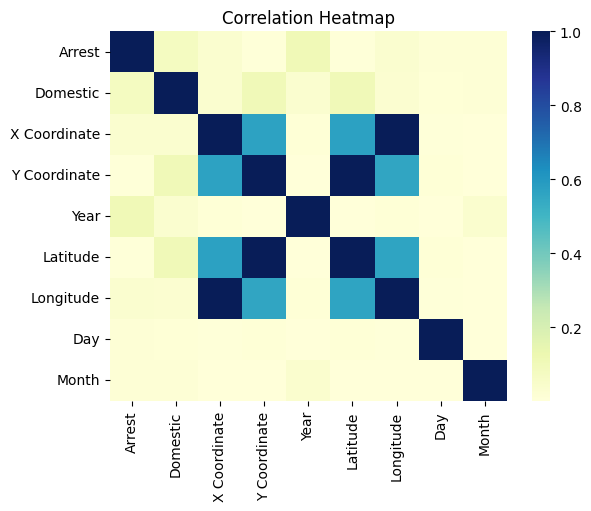

In [ ]:
nums = ['Arrest','Domestic', 'X Coordinate', 'Y Coordinate', 'Year', 'Latitude','Longitude','Day','Month']

corr_matrix = df[nums].corr(method = "spearman").abs()

ax = plt.axes()
sns.heatmap(corr_matrix, cmap="YlGnBu", ax = ax)
ax.set_title('Correlation Heatmap')
sns.set(rc={'figure.figsize':(6,4)}) # increase seaborn plot size
plt.show()

In [ ]:
df.drop('X Coordinate', axis=1, inplace=True) # correlation to Longitude
df.drop('Y Coordinate', axis=1, inplace=True) # correlation to Latitude

### Recheck Correlation

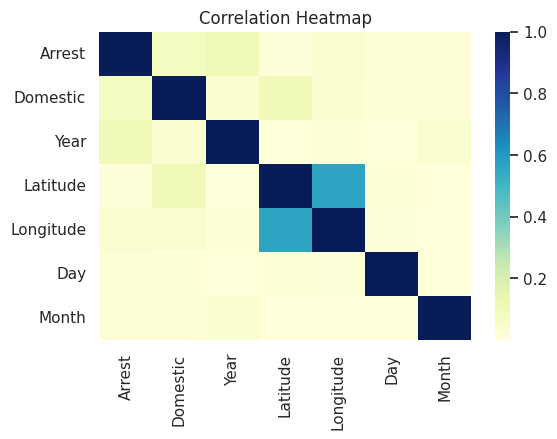

In [ ]:
nums = ['Arrest','Domestic', 'Year', 'Latitude','Longitude','Day','Month']

corr_matrix = df[nums].corr(method = "spearman").abs()

ax = plt.axes()
sns.heatmap(corr_matrix, cmap="YlGnBu", ax = ax)
ax.set_title('Correlation Heatmap')
plt.show()

### Check Missing Values

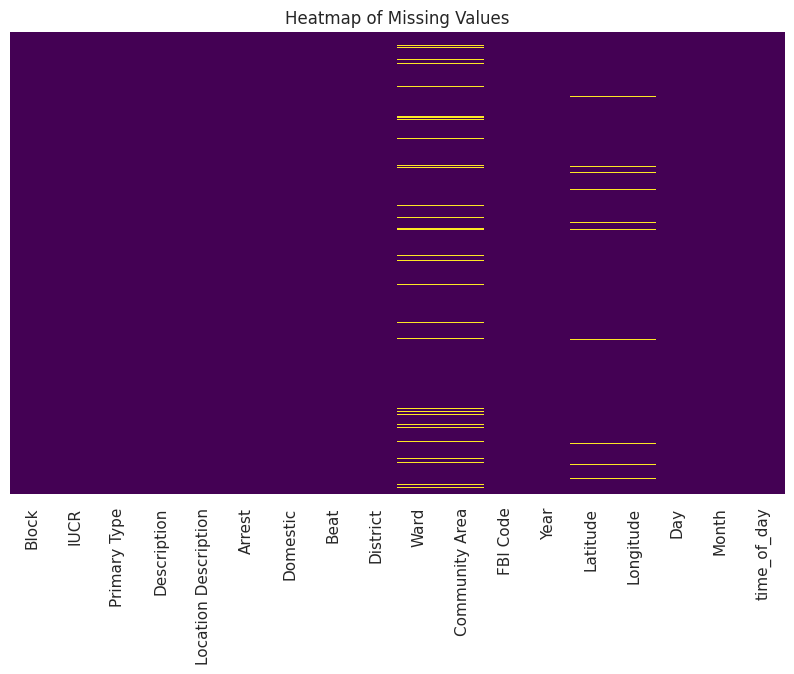

In [ ]:
# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Values')
plt.show()

In [ ]:
# Check missing values
print(f"Missing % for Ward: {100*df['Ward'].isnull().sum()/len(df):.2f}%")
print(f"Missing % for Community Area: {100*df['Community Area'].isnull().sum()/len(df):.2f}%")

Missing % for Ward: 7.17%
Missing % for Community Area: 7.12%


In [ ]:
# Remove correlation between Ward, Community Area
df.drop('Community Area', axis=1, inplace=True) # correlation to Ward

# Remove missing values
df.dropna(subset=['Latitude'], inplace=True) # drop missing values in Latitude/Longitude
df.dropna(subset=['Ward'], inplace=True) # drop missing values in Latitude/Longitude

df.reset_index(drop=True, inplace=True)
df.shape

(1968620, 17)

In [ ]:
print(f"Missing % for Ward: {100*df['Ward'].isnull().sum()/len(df):.2f}%")
print(f"Missing % for Latitude: {100*df['Latitude'].isnull().sum()/len(df):.2f}%")
print(f"Missing % for Longitude: {100*df['Longitude'].isnull().sum()/len(df):.2f}%")

Missing % for Ward: 0.00%
Missing % for Latitude: 0.00%
Missing % for Longitude: 0.00%


In [ ]:
df.head()

,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,FBI Code,Year,Latitude,Longitude,Day,Month,time_of_day
0,030XX W CERMAK RD,0460,BATTERY,SIMPLE,ALLEY,0,0,1033,10.0,24.0,08B,2015,41.851808,-87.702090,7,6,Afternoon
1,015XX N DAMEN AVE,0460,BATTERY,SIMPLE,STREET,0,0,1424,14.0,1.0,08B,2008,41.909944,-87.677450,16,2,Early Morning
2,026XX W EVERGREEN AVE,0460,BATTERY,SIMPLE,SIDEWALK,0,0,1423,14.0,26.0,08B,2006,41.905701,-87.692989,24,3,Afternoon
3,079XX S COTTAGE GROVE AVE,0890,THEFT,FROM BUILDING,SMALL RETAIL STORE,0,0,624,6.0,6.0,06,2009,41.750832,-87.605225,7,11,Evening
4,017XX N HOYNE AVE,0820,THEFT,$500 AND UNDER,STREET,0,0,1434,14.0,32.0,06,2014,41.913540,-87.679992,20,6,Night


### Create Data Sets with Missing Values (Selected an important feature)

In [ ]:
def CreateMissing(df, column, percentage):

  # Number of entries to remove
  num_to_remove = int(len(df) * (percentage/100))

  # Randomly choose indices to set to NaN
  np.random.seed(42)  # For reproducibility
  random_indices = np.random.choice(df.index, num_to_remove, replace=False)

  # Introduce missing values in column 'A'
  df.loc[random_indices, column] = np.nan

  return df

In [ ]:
df10 = df.copy()
df25 = df.copy()
df50 = df.copy()

df10 = CreateMissing(df10, 'FBI Code', 10)
df25 = CreateMissing(df25, 'FBI Code', 25)
df50 = CreateMissing(df50, 'FBI Code', 50)

print(f"Missing % for FBI Code in df10: {100*df10['FBI Code'].isnull().sum()/len(df):.2f}%")
print(f"Missing % for FBI Code in df25: {100*df25['FBI Code'].isnull().sum()/len(df):.2f}%")
print(f"Missing % for FBI Code in df50: {100*df50['FBI Code'].isnull().sum()/len(df):.2f}%")

Missing % for FBI Code in df10: 10.00%
Missing % for FBI Code in df25: 25.00%
Missing % for FBI Code in df50: 50.00%


___
## BASELINE MODELING WITH MEAN IMPUTATION

### BASELINE DATA PREP

In [ ]:
var_info, cat_list, num_list, bool_list, dt_list = GetDataInfo(df)
var_info

Data Frame Columns = 17
Data Frame Rows = 9162



,DataType,Uniques,Missing,Missing %,Duplicates
Column Name,,,,,
Block,object,6589,0,0.000000,2573
IUCR,object,216,0,0.000000,8946
Primary Type,object,26,0,0.000000,9136
Description,object,254,0,0.000000,8908
Location Description,object,113,6,0.065488,9048
Arrest,int64,2,0,0.000000,9160
Domestic,int64,2,0,0.000000,9160
Beat,object,302,0,0.000000,8860
District,object,23,0,0.000000,9139


In [ ]:
def DataPrepImputeWithMean(df, use_mean_impute = False):
  # Convert all object columns to categorical
  object_columns = df.select_dtypes(include='object').columns
  df[object_columns] = df[object_columns].apply(lambda x: x.astype('category'))

  # Drop Arrest rows with missing values
  df.dropna(subset=['Arrest'], inplace=True)

  # Define the target variable and features for the sampled data
  y = df['Arrest']
  X = df.drop(['Arrest'], axis=1)

  # Define categorical columns
  categorical_columns = ['Block', 'Description', 'Primary Type',
                        'Location Description', 'time_of_day',
                        'IUCR', 'Beat', 'District', 'Ward','FBI Code']

  # Convert categorical features to dummy variables
  X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

  # Convert all columns to numeric, coercing errors to NaN
  X = X.apply(pd.to_numeric, errors='coerce')

  # Ensure data types are optimized
  X = X.astype('float32')
  y = y.astype('float32')

  X.replace(to_replace=[None, '', 'NaN'], value=np.nan, inplace=True)
  y.replace(to_replace=[None, '', 'NaN'], value=np.nan, inplace=True)

  # Split the transformed dataset into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Saving feature names for later use
  feature_list = list(X_train.columns)

  # Impute missing values with the mean value in the training set of the sample
  if use_mean_impute:
    imputer = SimpleImputer(strategy='mean')
    #imputer = IterativeImputer()
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

  return X_train, X_test, y_train, y_test, feature_list

#### Create Data with Simple Imputer = Mean (for 10%, 25%, 50% missing)

In [ ]:
X_train_simpleimp10, X_test_simpleimp10, y_train_simpleimp10, y_test_simpleimp10, feature_list10 = DataPrepImputeWithMean(df10, use_mean_impute=True)
X_train_simpleimp25, X_test_simpleimp25, y_train_simpleimp25, y_test_simpleimp25, feature_list25 = DataPrepImputeWithMean(df25, use_mean_impute=True)
X_train_simpleimp50, X_test_simpleimp50, y_train_simpleimp50, y_test_simpleimp50, feature_list50 = DataPrepImputeWithMean(df50, use_mean_impute=True)

# check X train size
X_train10_df = pd.DataFrame(X_train_simpleimp10, columns=feature_list10)
X_train10_df.shape

### Define Models

In [ ]:
def run_gbm(X_train, y_train, X_test, y_test):
  gbm = GradientBoostingClassifier()
  gbm.fit(X_train, y_train)

  # Make predictions on the test set
  predictions = gbm.predict(X_test)

  # Evaluate the model's performance using accuracy
  base_gbm_accuracy = accuracy_score(y_test, predictions)
  print("GBM Accuracy:", base_gbm_accuracy)

  return gbm

def run_rf(X_train, y_train, X_test, y_test):
  # Train the model
  rf = RandomForestClassifier()
  rf.fit(X_train, y_train)

  # Make predictions on the test set
  predictions = rf.predict(X_test)

  # Evaluate the model's performance using accuracy
  accuracy = accuracy_score(y_test, predictions)
  print("RF Accuracy:", accuracy)

  return rf

def run_dt(X_train, y_train, X_test, y_test):
  # Train the model
  dt = tree.DecisionTreeClassifier()
  dt.fit(X_train, y_train)

  # Make predictions on the test set
  predictions = dt.predict(X_test)

  # Evaluate the model's performance using accuracy
  accuracy = accuracy_score(y_test, predictions)
  print("Decision Tree Accuracy:", accuracy)

  return dt

def run_ensemble_gbm_rf_dt(X_train, y_train, X_test, y_test):
  dt = tree.DecisionTreeClassifier()
  rf = RandomForestClassifier()
  gbm = GradientBoostingClassifier()

  # Create the Voting classifier with soft voting
  voting_clf = VotingClassifier(estimators=[('gbm', gbm), ('rf', rf), ('dt', dt)], voting='soft')

  # Fit the voting classifier to the training data of the sample
  voting_clf.fit(X_train, y_train)

  # Make predictions with the voting classifier on the test set of the sample
  voting_predictions = voting_clf.predict(X_test)

  # Evaluate the ensemble's performance on the sample
  accuracy = accuracy_score(y_test, voting_predictions)
  print("Voting Ensemble (GBM, RF, DT) Accuracy:", accuracy)

  return voting_clf

def run_ensemble_gbm_rf(X_train, y_train, X_test, y_test):
  dt = tree.DecisionTreeClassifier()
  rf = RandomForestClassifier()
  gbm = GradientBoostingClassifier()

  # Create the Voting classifier with soft voting
  voting_clf = VotingClassifier(estimators=[('gbm', gbm), ('rf', rf)], voting='soft')

  # Fit the voting classifier to the training data of the sample
  voting_clf.fit(X_train, y_train)

  # Make predictions with the voting classifier on the test set of the sample
  voting_predictions = voting_clf.predict(X_test)

  # Evaluate the ensemble's performance on the sample
  accuracy = accuracy_score(y_test, voting_predictions)
  print("Voting Ensemble (GBM, RF) Accuracy:", accuracy)

  return voting_clf


### GBM

In [ ]:
%%time
gbmsimple10 = run_gbm(X_train_simpleimp10, y_train_simpleimp10, X_test_simpleimp10, y_test_simpleimp10)

In [ ]:
%%time
gbmsimple25 = run_gbm(X_train_simpleimp25, y_train_simpleimp25, X_test_simpleimp25, y_test_simpleimp25)

In [ ]:
%%time
gbmsimple50 = run_gbm(X_train_simpleimp50, y_train_simpleimp50, X_test_simpleimp50, y_test_simpleimp50)

,Feature,Importance
0,Primary Type_NARCOTICS,0.540682
1,Primary Type_CRIMINAL TRESPASS,0.062608
2,Primary Type_PROSTITUTION,0.044547
3,IUCR_143.1,0.032429
4,IUCR_0860,0.032090
...,...,...
95,Block_111XX S VERNON AVE,0.000386
96,Description_SEXUAL EXPLOITATION OF A CHILD,0.000382
97,Ward_42.0,0.000378
98,Block_004XX S LOCKWOOD AVE,0.000377


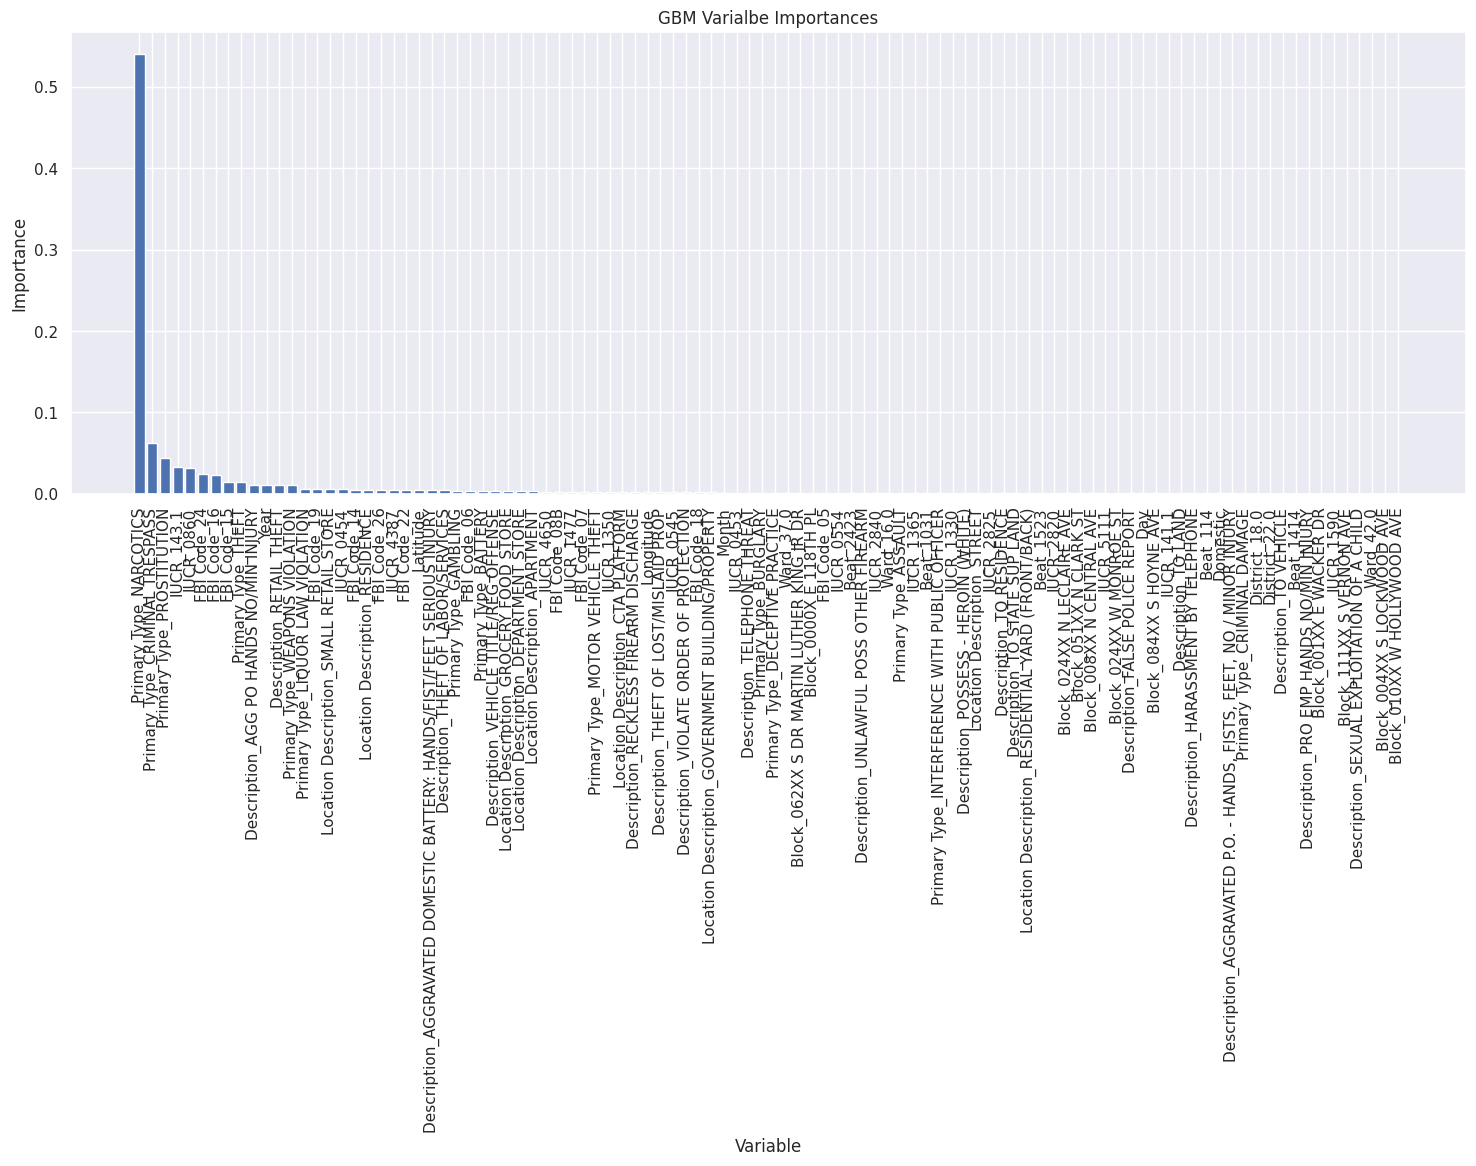

In [ ]:
PlotFeatureImportance(gbmsimple10, feature_list10, 'GBM Varialbe Importances')

### Random Forest

In [ ]:
%%time
rfsimple10 = run_rf(X_train_simpleimp10, y_train_simpleimp10, X_test_simpleimp10, y_test_simpleimp10)

In [ ]:
%%time
rfsimple25 = run_rf(X_train_simpleimp25, y_train_simpleimp25, X_test_simpleimp25, y_test_simpleimp25)

In [ ]:
%%time
rfsimple50 = run_rf(X_train_simpleimp50, y_train_simpleimp50, X_test_simpleimp50, y_test_simpleimp50)

,Feature,Importance
0,FBI Code_18,0.071088
1,Primary Type_NARCOTICS,0.061936
2,IUCR_1811,0.028066
3,Latitude,0.022966
4,Year,0.022432
...,...,...
95,District_4.0,0.001497
96,IUCR_0910,0.001492
97,District_8.0,0.001478
98,Ward_37.0,0.001470


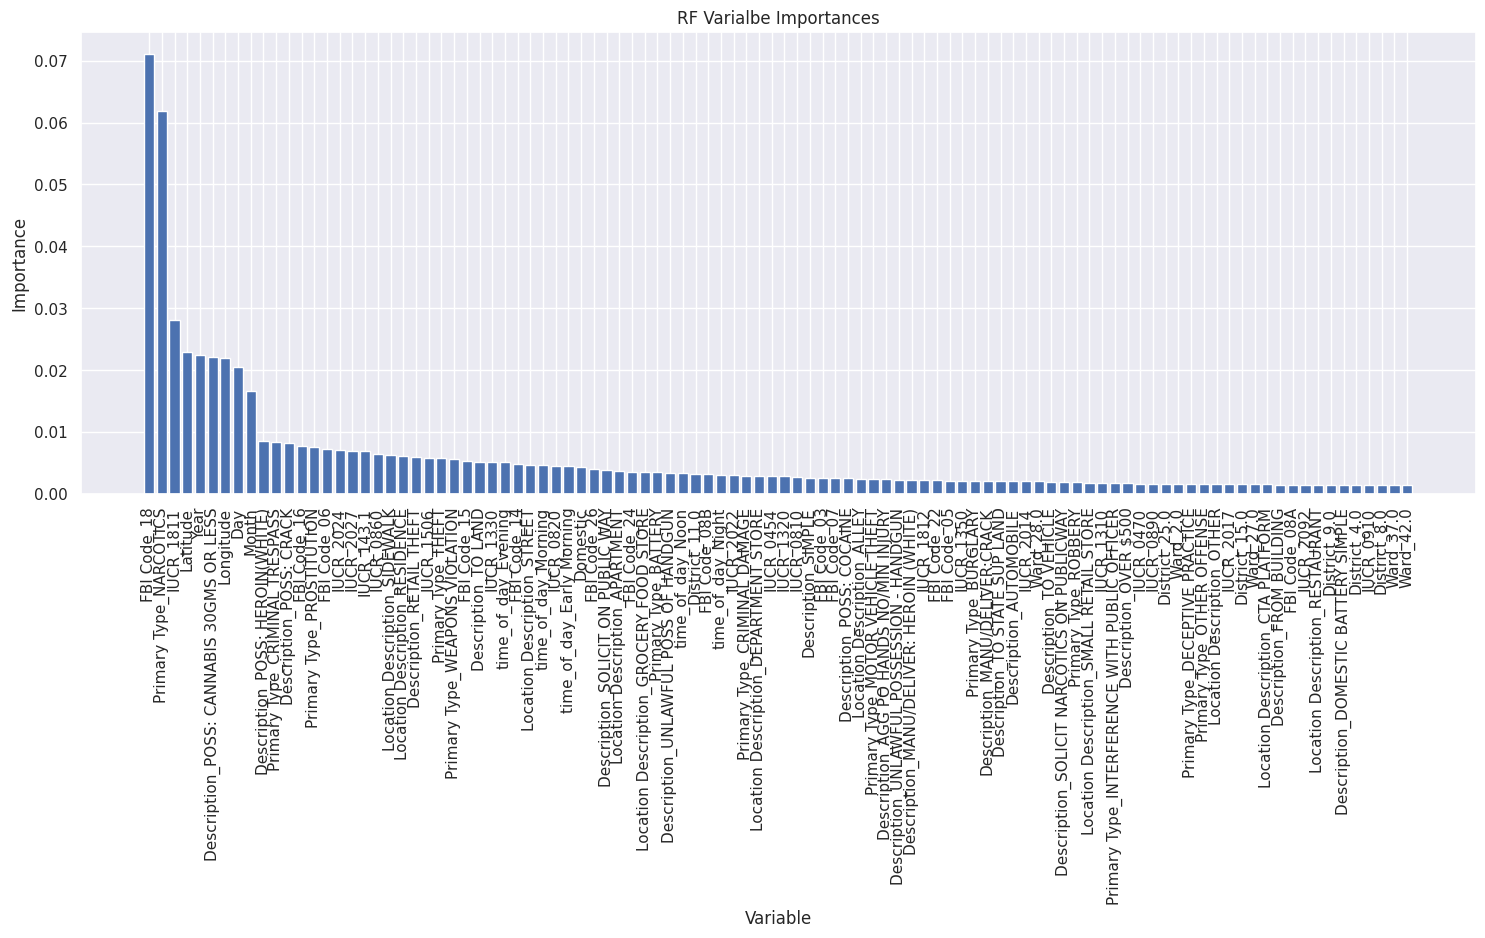

In [ ]:
PlotFeatureImportance(rfsimple10, feature_list10, 'RF Varialbe Importances')

### Decision Tree

In [ ]:
%%time
dt_simple10 = run_dt(X_train_simpleimp10, y_train_simpleimp10, X_test_simpleimp10, y_test_simpleimp10)

In [ ]:
%%time
dt_simple25 = run_dt(X_train_simpleimp25, y_train_simpleimp25, X_test_simpleimp25, y_test_simpleimp25)

In [ ]:
%%time
dt_simple50 = run_dt(X_train_simpleimp50, y_train_simpleimp50, X_test_simpleimp50, y_test_simpleimp50)

,Feature,Importance
0,Primary Type_NARCOTICS,0.298360
1,Primary Type_PROSTITUTION,0.035896
2,Primary Type_CRIMINAL TRESPASS,0.035685
3,IUCR_143.1,0.031267
4,IUCR_0860,0.024179
...,...,...
95,Primary Type_THEFT,0.000789
96,Description_FALSE POLICE REPORT,0.000776
97,Block_076XX S CICERO AVE,0.000772
98,time_of_day_Night,0.000771


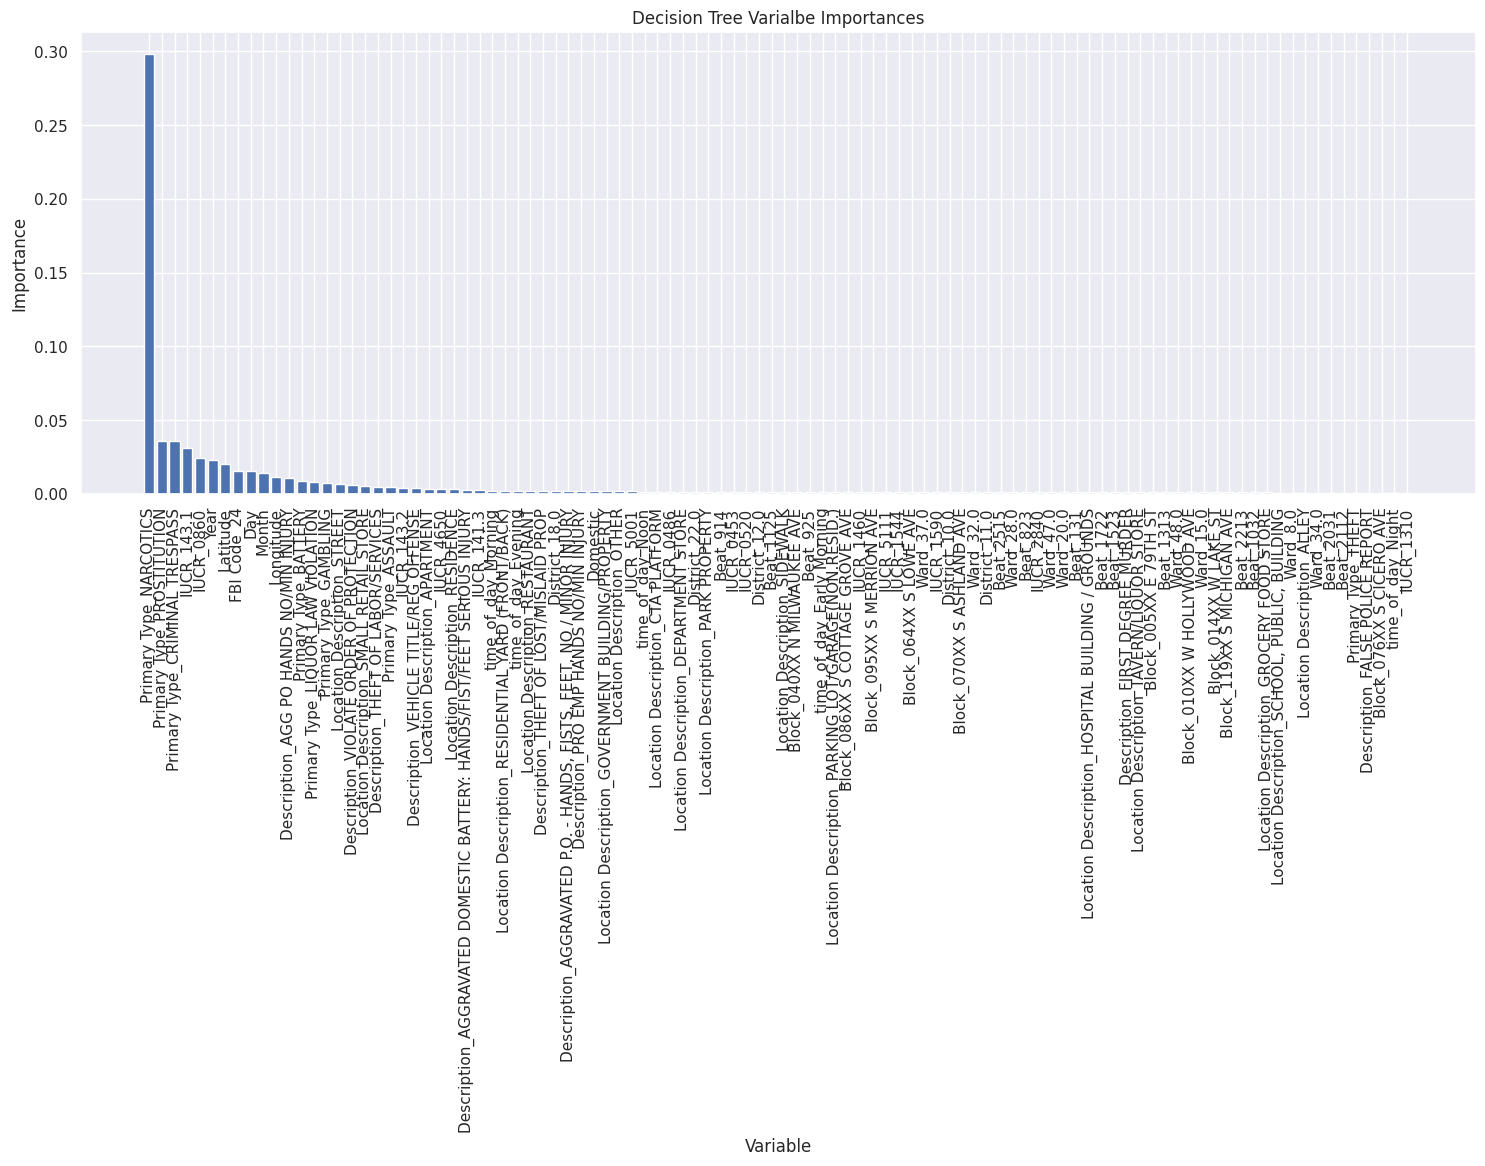

In [ ]:
PlotFeatureImportance(dt_simple10, feature_list10, 'Decision Tree Varialbe Importances')

### Ensemble (GBM, RF, DT)

In [ ]:
%%time
ensemble1_10 = run_ensemble_gbm_rf_dt(X_train_simpleimp10, y_train_simpleimp10, X_test_simpleimp10, y_test_simpleimp10)

In [ ]:
%%time
ensemble1_25 = run_ensemble_gbm_rf_dt(X_train_simpleimp25, y_train_simpleimp25, X_test_simpleimp25, y_test_simpleimp25)

In [ ]:
%%time
ensemble1_50 = run_ensemble_gbm_rf_dt(X_train_simpleimp50, y_train_simpleimp50, X_test_simpleimp50, y_test_simpleimp50)

In [ ]:
# # Extract feature importances from the RandomForest and GradientBoosting classifiers
# rf_importances = rf.feature_importances_
# gb_importances = gbm.feature_importances_
# dt_importances = dt.feature_importances_

# # Average the feature importances
# # (This can be adjusted based on the contribution or importance of each classifier)
# feature_importances = np.mean([rf_importances, gb_importances, dt_importances], axis=0)

# # Create a DataFrame for better visualization
# importance = pd.DataFrame({
#     'Feature': feature_list,
#     'Importance': feature_importances
# })
# importance = importance.sort_values(by='Importance', ascending=False)[0:100]
# plt.figure(figsize=(18, 6))

# # list of x locations for plotting
# x_values = importance['Feature']

# # Make a bar chart
# plt.bar(importance['Feature'], importance['Importance'], orientation = 'vertical')

# # Tick labels for x axis
# plt.xticks(x_values, importance['Feature'], rotation='vertical')

# # Axis labels and title
# plt.ylabel('Importance'); plt.xlabel('Variable')
# plt.title('Aggregated Feature Importance in Voting Classifier (GBM, RF, DT)');

In [ ]:
# importance.to_csv('feature_importance.csv', encoding='utf-8', index=False)

### Ensemble (GBM, RF)

In [ ]:
%%time
ensemble2_10 = run_ensemble_gbm_rf(X_train_simpleimp10, y_train_simpleimp10, X_test_simpleimp10, y_test_simpleimp10)

In [ ]:
%%time
ensemble2_25 = run_ensemble_gbm_rf(X_train_simpleimp25, y_train_simpleimp25, X_test_simpleimp25, y_test_simpleimp25)

In [ ]:
%%time
ensemble2_50 = run_ensemble_gbm_rf(X_train_simpleimp50, y_train_simpleimp50, X_test_simpleimp50, y_test_simpleimp50)

In [ ]:
# # Extract feature importances from the RandomForest and GradientBoosting classifiers
# rf_importances = rf.feature_importances_
# gb_importances = gbm.feature_importances_

# # Average the feature importances
# # (This can be adjusted based on the contribution or importance of each classifier)
# feature_importances = np.mean([rf_importances, gb_importances], axis=0)

# # Create a DataFrame for better visualization
# importance = pd.DataFrame({
#     'Feature': feature_list,
#     'Importance': feature_importances
# })
# importance = importance.sort_values(by='Importance', ascending=False)[0:100]
# plt.figure(figsize=(18, 6))

# # list of x locations for plotting
# x_values = importance['Feature']

# # Make a bar chart
# plt.bar(importance['Feature'], importance['Importance'], orientation = 'vertical')

# # Tick labels for x axis
# plt.xticks(x_values, importance['Feature'], rotation='vertical')

# # Axis labels and title
# plt.ylabel('Importance'); plt.xlabel('Variable')
# plt.title('Aggregated Feature Importance in Voting Classifier (GBM, RF)');

___
## MODELING FOR IMPUTATION 10% MISSING

### Data Prep for Using a Model as an Imputer for 'FBI Code', 10% Missing

In [ ]:
df10_fbi = df10.copy()
df10_fbi.reset_index(drop=True)

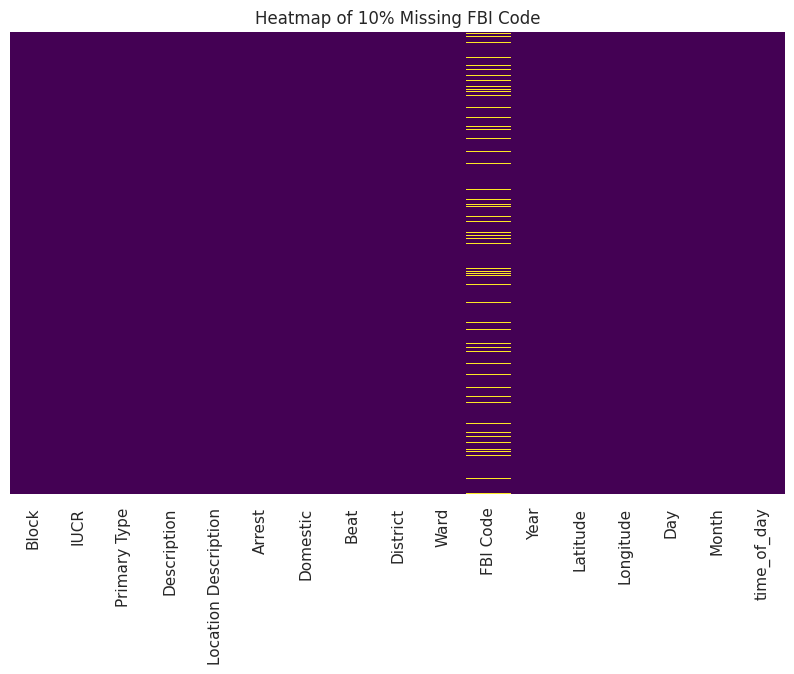

In [ ]:


# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df10_fbi.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of 10% Missing FBI Code')
plt.show()

In [ ]:
print(f"Missing % for FBI Code: {100*df10_fbi['FBI Code'].isnull().sum()/len(df10_fbi):.2f}%")

Missing % for FBI Code: 10.00%


### IMPUTATION DATA PREP, 10% MISSING

In [ ]:
# get missing indices
missing10_indices = df10_fbi[df10_fbi["FBI Code"].isna()].index

# Select non-missing indices
non_missing90_indices = df10_fbi.index.difference(missing10_indices)

# Convert all object columns to categorical
object_columns = df10_fbi.select_dtypes(include='object').columns
df10_fbi[object_columns] = df10_fbi[object_columns].apply(lambda x: x.astype('category'))

# Define the target variable and features
y_miss10 = df10_fbi['FBI Code'].cat.codes # encode y
X_miss10 = df10_fbi.drop(['FBI Code'], axis=1)

# Define categorical columns
cat_cols = ['Block', 'IUCR', 'Primary Type', 'Description', 'Location Description',
            'Beat', 'District', 'Ward', 'time_of_day']

# Convert categorical features to dummy variables
X_miss10_onehot = pd.get_dummies(X_miss10, columns=cat_cols, drop_first=False)

# Convert all columns to numeric, coercing errors to NaN
X_miss10_onehot = X_miss10_onehot.apply(pd.to_numeric, errors='coerce')

# Ensure data types are optimized
X_miss10_onehot = X_miss10_onehot.astype('float32')
y_miss10 = y_miss10.astype('float32')

X_90_onehot = X_miss10_onehot.loc[non_missing90_indices]     # X with the 90% no missing FBI Code
X_missing10_onehot = X_miss10_onehot.loc[missing10_indices]  # X with the 10% missing FBI Code
y_90 = y_miss10.loc[non_missing90_indices]                   # y with the 90% no missing FBI Code
y_missing10 = y_miss10.loc[missing10_indices]                # y with the 10% missing FBI Code

# Split the transformed dataset into training and testing sets
X_train_miss10, X_test_miss10, y_train_miss10, y_test_miss10 = train_test_split(X_90_onehot, y_90, test_size=0.2, random_state=42)

### RF for 'FBI Code' Imputation, 10% Missing

In [ ]:
# Train the model using XGBClassifier with enable_categorical=True
rf_fbi = RandomForestClassifier()
rf_fbi.fit(X_train_miss10, y_train_miss10)

# Make predictions on the test set
fbi_predictions = rf_fbi.predict(X_test_miss10)

# Evaluate the model's performance using accuracy
fbi_accuracy = accuracy_score(y_test_miss10, fbi_predictions)
print("FBI Code RF Accuracy:", fbi_accuracy)

# Classification report
# print("Classification Report:")
#print(classification_report(y_test_miss10, fbi_predictions, target_names=df10_fbi['FBI Code'].astype('category').cat.categories))

### Impute Missing 'FBI Code', 10% Missing



In [ ]:
df10_fbi = df10.copy()
print(f"Missing % for FBI Code: {100*df10_fbi['FBI Code'].isnull().sum()/len(df10_fbi):.2f}%")

# Predict the missing values
imputed_fbi = rf_fbi.predict(X_missing10_onehot)

# Add new categories to the 'FBI Code' column
df10_fbi['FBI Code'] = df10_fbi['FBI Code'].astype('category')
new_categories = pd.Categorical(imputed_fbi).categories
df10_fbi['FBI Code'] = df10_fbi['FBI Code'].cat.add_categories(new_categories)

# Replace missing values in the original dataframe
df10_fbi.loc[missing10_indices, 'FBI Code'] = imputed_fbi

print(f"Missing % for FBI Code: {100*df10_fbi['FBI Code'].isnull().sum()/len(df10_fbi):.2f}%")

In [ ]:
X_train10, X_test10, y_train10, y_test10, feature_list10 = DataPrepImputeWithMean(df10_fbi)

### CHECK PERFORMANCE, 10% MISSING

In [ ]:
gbm10 = run_gbm(X_train10, y_train10, X_test10, y_test10)

In [ ]:
rf10 = run_rf(X_train10, y_train10, X_test10, y_test10)

In [ ]:
dt10 = run_dt(X_train10, y_train10, X_test10, y_test10)

In [ ]:
ensemble1_10 = run_ensemble_gbm_rf_dt(X_train10, y_train10, X_test10, y_test10)

In [ ]:
ensemble2_10 = run_ensemble_gbm_rf(X_train10, y_train10, X_test10, y_test10)

___

___
## MODELING FOR IMPUTATION 25% MISSING

### Data Prep for Using a Model as an Imputer for 'FBI Code', 10% Missing

In [ ]:
df25_fbi = df25.copy()
df25_fbi.reset_index(drop=True)

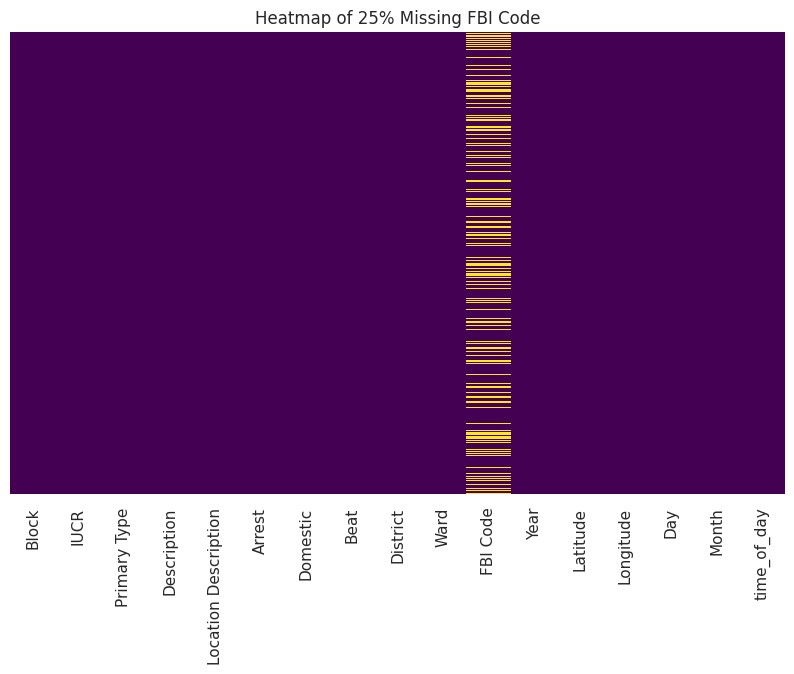

In [ ]:


# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df25_fbi.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of 25% Missing FBI Code')
plt.show()

In [ ]:
print(f"Missing % for FBI Code: {100*df25_fbi['FBI Code'].isnull().sum()/len(df25_fbi):.2f}%")

Missing % for FBI Code: 24.99%


### IMPUTATION DATA PREP, 25% MISSING

In [ ]:
# get missing indices
missing25_indices = df25_fbi[df25_fbi["FBI Code"].isna()].index

# Select non-missing indices
non_missing75_indices = df25_fbi.index.difference(missing25_indices)

# Convert all object columns to categorical
object_columns = df25_fbi.select_dtypes(include='object').columns
df25_fbi[object_columns] = df25_fbi[object_columns].apply(lambda x: x.astype('category'))

# Define the target variable and features
y_miss25 = df25_fbi['FBI Code'].cat.codes # encode y
X_miss25 = df25_fbi.drop(['FBI Code'], axis=1)

# Define categorical columns
cat_cols = ['Block', 'IUCR', 'Primary Type', 'Description', 'Location Description',
            'Beat', 'District', 'Ward', 'time_of_day']

# Convert categorical features to dummy variables
X_miss25_onehot = pd.get_dummies(X_miss25, columns=cat_cols, drop_first=False)

# Convert all columns to numeric, coercing errors to NaN
X_miss25_onehot = X_miss25_onehot.apply(pd.to_numeric, errors='coerce')

# Ensure data types are optimized
X_miss25_onehot = X_miss25_onehot.astype('float32')
y_miss25 = y_miss25.astype('float32')

X_75_onehot = X_miss25_onehot.loc[non_missing75_indices]     # X with the 75% no missing FBI Code
X_missing25_onehot = X_miss25_onehot.loc[missing25_indices]  # X with the 25% missing FBI Code
y_75 = y_miss25.loc[non_missing75_indices]                   # y with the 75% no missing FBI Code
y_missing25 = y_miss25.loc[missing25_indices]                # y with the 25% missing FBI Code

# Split the transformed dataset into training and testing sets
X_train_miss25, X_test_miss25, y_train_miss25, y_test_miss25 = train_test_split(X_75_onehot, y_75, test_size=0.2, random_state=42)

### RF for 'FBI Code' Imputation, 25% Missing

In [ ]:
# Train the model using XGBClassifier with enable_categorical=True
rf_fbi = RandomForestClassifier()
rf_fbi.fit(X_train_miss25, y_train_miss25)

# Make predictions on the test set
fbi_predictions = rf_fbi.predict(X_test_miss25)

# Evaluate the model's performance using accuracy
fbi_accuracy = accuracy_score(y_test_miss25, fbi_predictions)
print("FBI Code RF Accuracy:", fbi_accuracy)

# Classification report
print("Classification Report:")
#print(classification_report(y_test_miss25, fbi_predictions, target_names=df25_fbi['FBI Code'].astype('category').cat.categories))

### Impute Missing 'FBI Code', 25% Missing



In [ ]:
df25_fbi = df25.copy()
print(f"Missing % for FBI Code: {100*df25_fbi['FBI Code'].isnull().sum()/len(df25_fbi):.2f}%")

# Predict the missing values
imputed_fbi = rf_fbi.predict(X_missing25_onehot)

# Add new categories to the 'FBI Code' column
df25_fbi['FBI Code'] = df25_fbi['FBI Code'].astype('category')
new_categories = pd.Categorical(imputed_fbi).categories
df25_fbi['FBI Code'] = df25_fbi['FBI Code'].cat.add_categories(new_categories)

# Replace missing values in the original dataframe
df25_fbi.loc[missing25_indices, 'FBI Code'] = imputed_fbi

print(f"Missing % for FBI Code: {100*df25_fbi['FBI Code'].isnull().sum()/len(df25_fbi):.2f}%")

In [ ]:
X_train25, X_test25, y_train25, y_test25, feature_list25 = DataPrepImputeWithMean(df25_fbi)

### CHECK PERFORMANCE, 25% MISSING

In [ ]:
rf25 = run_rf(X_train25, y_train25, X_train25, y_train25)

In [ ]:
gbm25 = run_gbm(X_train25, y_train25, X_test25, y_test25)

In [ ]:
rf25 = run_rf(X_train25, y_train25, X_test25, y_test25)

In [ ]:
dt25 = run_dt(X_train25, y_train25, X_test25, y_test25)

In [ ]:
ensemble1_25 = run_ensemble_gbm_rf_dt(X_train25, y_train25, X_test25, y_test25)

In [ ]:
ensemble2_25 = run_ensemble_gbm_rf(X_train25, y_train25, X_test25, y_test25)

___
## MODELING FOR IMPUTATION 50% MISSING

### Data Prep for Using a Model as an Imputer for 'FBI Code', 50% Missing

In [ ]:
df50_fbi = df50.copy()
df50_fbi.reset_index(drop=True)

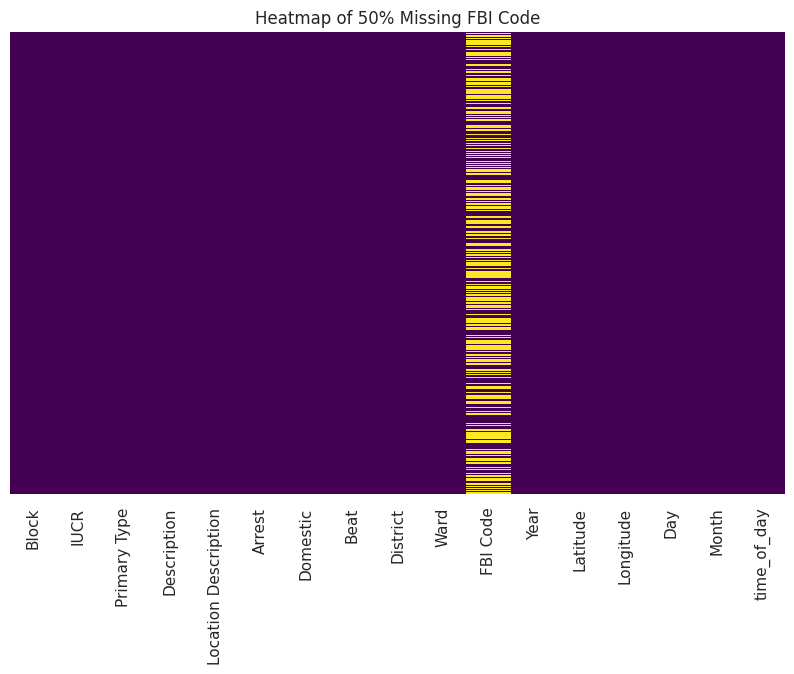

In [ ]:


# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df50_fbi.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of 50% Missing FBI Code')
plt.show()

In [ ]:
print(f"Missing % for FBI Code: {100*df50_fbi['FBI Code'].isnull().sum()/len(df50_fbi):.2f}%")

Missing % for FBI Code: 50.00%


### IMPUTATION DATA PREP, 50% MISSING

In [ ]:
# get missing indices
missing50_indices = df50_fbi[df50_fbi["FBI Code"].isna()].index

# Select non-missing indices
non_missing50_indices = df50_fbi.index.difference(missing50_indices)

# Convert all object columns to categorical
object_columns = df50_fbi.select_dtypes(include='object').columns
df50_fbi[object_columns] = df50_fbi[object_columns].apply(lambda x: x.astype('category'))

# Define the target variable and features
y_miss50 = df50_fbi['FBI Code'].cat.codes # encode y
X_miss50 = df50_fbi.drop(['FBI Code'], axis=1)

# Define categorical columns
cat_cols = ['Block', 'IUCR', 'Primary Type', 'Description', 'Location Description',
            'Beat', 'District', 'Ward', 'time_of_day']

# Convert categorical features to dummy variables
X_miss50_onehot = pd.get_dummies(X_miss50, columns=cat_cols, drop_first=False)

# Convert all columns to numeric, coercing errors to NaN
X_miss50_onehot = X_miss50_onehot.apply(pd.to_numeric, errors='coerce')

# Ensure data types are optimized
X_miss50_onehot = X_miss50_onehot.astype('float32')
y_miss50 = y_miss50.astype('float32')

X_50_onehot = X_miss50_onehot.loc[non_missing50_indices]     # X with the 50% no missing FBI Code
X_missing50_onehot = X_miss50_onehot.loc[missing50_indices]  # X with the 50% missing FBI Code
y_50 = y_miss50.loc[non_missing50_indices]                   # y with the 50% no missing FBI Code
y_missing50 = y_miss50.loc[missing50_indices]                # y with the 50% missing FBI Code

# Split the transformed dataset into training and testing sets
X_train_miss50, X_test_miss50, y_train_miss50, y_test_miss50 = train_test_split(X_50_onehot, y_50, test_size=0.2, random_state=42)

### RF for 'FBI Code' Imputation, 50% Missing

In [ ]:
# Train the model using XGBClassifier with enable_categorical=True
rf_fbi = RandomForestClassifier()
rf_fbi.fit(X_train_miss50, y_train_miss50)

# Make predictions on the test set
fbi_predictions = rf_fbi.predict(X_test_miss50)

# Evaluate the model's performance using accuracy
fbi_accuracy = accuracy_score(y_test_miss50, fbi_predictions)
print("FBI Code RF Accuracy:", fbi_accuracy)

# Classification report
print("Classification Report:")
#print(classification_report(y_test_miss25, fbi_predictions, target_names=df25_fbi['FBI Code'].astype('category').cat.categories))

### Impute Missing 'FBI Code', 50% Missing



In [ ]:
df50_fbi = df50.copy()
print(f"Missing % for FBI Code: {100*df50_fbi['FBI Code'].isnull().sum()/len(df50_fbi):.2f}%")

# Predict the missing values
imputed_fbi = rf_fbi.predict(X_missing50_onehot)

# Add new categories to the 'FBI Code' column
df50_fbi['FBI Code'] = df50_fbi['FBI Code'].astype('category')
new_categories = pd.Categorical(imputed_fbi).categories
df50_fbi['FBI Code'] = df50_fbi['FBI Code'].cat.add_categories(new_categories)

# Replace missing values in the original dataframe
df50_fbi.loc[missing50_indices, 'FBI Code'] = imputed_fbi

print(f"Missing % for FBI Code: {100*df50_fbi['FBI Code'].isnull().sum()/len(df50_fbi):.2f}%")

NameError: name 'df50' is not defined

In [ ]:
X_train50, X_test50, y_train50, y_test50, feature_list50 = DataPrepImputeWithMean(df50_fbi)

### CHECK PERFORMANCE RF, 50% MISSING

In [ ]:
gbm50 = run_gbm(X_train50, y_train50, X_test50, y_test50)

GBM Accuracy: 0.8848881614839061


In [ ]:
rf50 = run_rf(X_train50, y_train50, X_test50, y_test50)

RF Accuracy: 0.8870703764320785


In [ ]:
dt50 = run_dt(X_train50, y_train50, X_test50, y_test50)

Decision Tree Accuracy: 0.8565193671576651


In [ ]:
ensemble2_50 = run_ensemble_gbm_rf_dt(X_train50, y_train50, X_test50, y_test50)

Voting Ensemble (GBM, RF, DT) Accuracy: 0.8767048554282597


In [ ]:
ensemble2_50 = run_ensemble_gbm_rf(X_train50, y_train50, X_test50, y_test50)

Voting Ensemble (GBM, RF) Accuracy: 0.8854337152209493
